# Reinforcement Learning in action

## 1. Introduction

Let's assume we need to manage the energy flow of a building powered by solar panel system with a battery storage as shown in Figure 1. When solar PV generation is not sufficient to cater to the demand, the main grid supplies the mismatch at a varying (with time) price. Further the cost of $CO_2$ produced at a specific time by the grid is also considered for the cost.

<img src="files/data/building.png" width=550>
<p style="text-align: center; font-weight:bold;">Figure 1: Set up of building energy management system</p>

Our task in this tutorail is to charge or discharge the battery accordingly so that the overall cost is minimized.

This tutorial is based on the simulation engine [Pymgrid](https://github.com/Total-RD/pymgrid) by Total-RD

## 2. Install and imports

In [1]:
# first we will download the (custom) pymgrid library
# !pip install git+https://github.com/Wenuka/pymgrid/

In [2]:
import sys
from pymgrid import MicrogridGenerator as mg
import matplotlib.pyplot as plt
import numpy as np
import os
import time

from helper_functions import *

## 3. Generate Microgrids (a.k.a Building+PV+Battery+grid System)

In this specific case, the microgrid is defined as the building (energy demand) Solar panel (PV), inhouse battery pack which is also connected to the grid

In [3]:
# First we create the environment and the microgrid
env = mg.MicrogridGenerator(nb_microgrid=1, path="./data/pymgrid_data")  # we can use a custom file to simulate the load and the PV
env.generate_microgrid(verbose=False)
mg0 = env.microgrids[0]

In [4]:
mg0.architecture  # architecture of the microgrid 
# mg0.parameters  # parameters of the microgrid 

{'PV': 1, 'battery': 1, 'genset': 0, 'grid': 1}

NOTE: In this tutorial, we do not consider a generator (genset). Possible ways to integrate generation will be taken into the discussion at the end of the tutorial

## 4. Defining the Reward

RL always works with reward. Therefore, we need to define the reward at the begining. Then we can write algorithms so that our agent can learn to maximize the reward.

In this, we are trying to reduce (Minimize) the overall cost of the building. Therefore we can easily define the reward as the **minus cost**. So agent maximizing the reward means minimizing the cost.

The total cost consists of the cost of eleectricity and the penalty for $CO_2$ produced by the grid.

## 5. Q table

The state of the system explains the present conditions of the system. 
 
As we already learned, in Q learning, we try to guess the expected discounted future reward for each **State** for each **action**. 

Therefore, we maintain a Q-table to store these values. By doing this, we maintain rows for each State and columns for each Action (see Figure 2). So each value inside the Q-table is the Q-value (expected discounted future reward) for a given state and for a given action

<img src="files/data/qtable.png" width=550>
<p style="text-align: center; font-weight:bold;">Figure 2: Q table consisting of actions and states</p>

## 6. Defining the State 

Before starting the learning process, we need to define the states and the actions. 

Let us define the states first. To help the process, we will first plot a few graphs for the next 24 time steps (hours).

(extra note: forecast function forecast next 24 steps by default you can change it to N steps by **mg0.set_horizon(N)** )

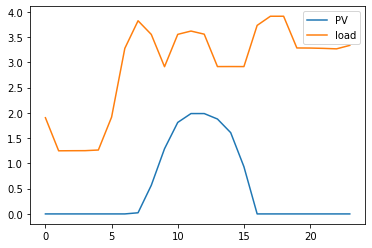

In [5]:
plt.plot(mg0.forecast_pv(), label="PV")
plt.plot(mg0.forecast_load(), label="load")
plt.legend()
# as we can see PV and Load is varying with the  time

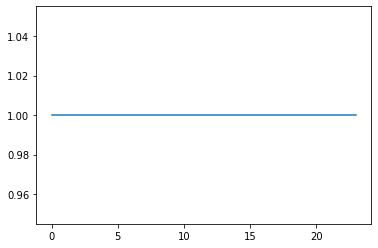

In [6]:
plt.plot(mg0.forecast_grid_status())  
# Here we observe that the microgrid is always connected to the utility grid (no change)

As we know, the environment in this is defined by four factors (Figure 3), namely,
* Load (kW)
* PV (kW)
* Battery (charge percentage)
* Grid connectivity (Grid price is not provided by the simulation environment)

<img src="files/data/environment.png" width=500>
<p style="text-align: center; font-weight:bold;">Figure 3: Energy interactions to state definition</p>

So, we can simply describe state by **(load, PV, Battery Percentage, Grid connectivity)** where Battery Percentage is (battery charge level \state of charge of battery)

1. Do we need all these variables to define the state? 

2. What variables/factors can you eliminate? 

3. Given our problem statement, what variables can you combine?

**Discuss!**

Answer:
* We can remove grid connectivity in here as it is always 1
* We can combine Load and PV as it is always the Net_load (load-PV) that needed to be considered.

Therefore the state can be defined as **(Net_load, battery %)**

Extra Note: we can also define the state as (load, PV, battery %) and continue. Then the only problem will be the inefficient learning due to the (relatively) un-necessarily bigger state space.

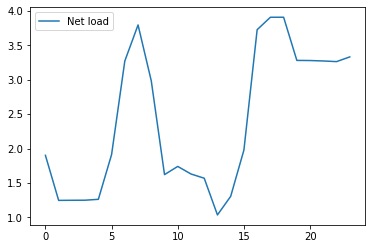

In [7]:
plt.plot(mg0.forecast_load()-mg0.forecast_pv(), label="Net load")
plt.legend()

In [8]:
mg0.set_horizon(24*365)
overall_net_load = mg0.forecast_load()-mg0.forecast_pv()
overal_min = min(overall_net_load)
overal_max = max(overall_net_load)
discretize_interval = 1
net_load_params = (overal_min, overal_max, discretize_interval)
mg0.set_horizon(24)
f"max: {overal_max:.2f}, min : {overal_min:.2f} interval: {discretize_interval}"

'max: 5.32, min : -1.71 interval: 1'

Another problem we face here is how to create Q-table when the variables in the state definition are continuous. 

For this, we **discretize the variable**. For example in this tutorial, we round the kW to the nearest decimal and battery percentage to the nearest 0.1

In [9]:
# For a given instences, you can see the environment and other values like this
current_load = mg0.load
current_pv = mg0.pv
battery_capacity = mg0.battery.capacity
battery_state_of_charge = mg0.battery.soc
# current_cost = mg0.get_cost() ## can be used only after running atleast one step of the microgrid (eg. mg.run(action) )

## 7. Designing the Actions

Since we have defined the states, let's try to define the actions that our agent need to perform to maximize the reward. 

These are the four actions that we are suggesting
* action 0: battery_charge
* action 1: battery_discharge
* action 2: grid_import
* action 3: grid_export



However, our simulation engine does not know what these actions are.

For this, we have to map these actions to the simulation engines control signals

In [10]:
def actions_agent(mg0, action):
    pv = mg0.pv
    load = mg0.load
    net_load = load - pv
    capa_to_charge = mg0.battery.capa_to_charge  # remaining capacity to charge of the battery
    p_charge_max = mg0.battery.p_charge_max  # charge speed of the battery
    p_charge = max(0,min(-net_load, capa_to_charge, p_charge_max))  # charge value for the time 
    
    capa_to_discharge = mg0.battery.capa_to_discharge  # capacity of discharge
    p_discharge_max = mg0.battery.p_discharge_max  # per hour discharge rate
    p_discharge = max(0,min(net_load, capa_to_discharge, p_discharge_max))  # discharge value for the time 
          
    if action == 0:       
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': p_charge,
                        'battery_discharge': 0,
                        'grid_import': 0,
                        'grid_export':max(0,pv - min(pv,load) - p_charge)
                       }            
    elif action ==1:    
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': p_discharge,
                        'grid_import': max(0,load - min(pv,load) - p_discharge),
                        'grid_export':0
                       }
    elif action ==2:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': 0,
                        'grid_import': abs(net_load),
                        'grid_export':0
                       }
    elif action == 3:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': 0,
                        'grid_import': 0,
                        'grid_export':abs(net_load)
                       }
    
    return control_dict

## 8. Initializing the Q table

In [11]:
def init_qtable(mg0, nb_action, net_load_params):

    state = []
    Q = {}

    for i in range(round(net_load_params[0]),round(net_load_params[1])+1, 1):  # last 1 in the range is the discretize interval
        
        for j in np.arange(round(mg0.battery.soc_min,1),round(mg0.battery.soc_max+0.1,1),0.1):
            
            j = round(j,1)
            state.append((i,j)) 
    
    for s in state:

        Q[s] = {}

        for a in range(nb_action):

            Q[s][a] = 0 # Initialize Q(s,a) at zero (We normally initialize Q at a higher reward than usual so that all the options are getting explored)

    return Q

**Policy** is the way we select the action, given the Q-values. 

In this tutorial we have selected the famous **epsilon greedy policy**.

To explain what this is, given a state, we act greedily (choose the action with the highest Q-value) 1-epsilon times while we randomly select an action epsilon of the time where the epsilon is a positive decreasing value less than 1. If interested, please take a look into the helper_functions.py where we have defined the policy.

Since we act randomly epsilon times, our agent gets the chance to explore the environment. Since we decrease the epsilon with time, the agent takes less and less random actions and always tries to act greedily.

Selecting epsilon is an important task and this is normally called the *Explore-Exploit dilemma.*

## 9. Q learning

To recap, here is the Q-learning algo (from Sutton and Barto's book)
<img src="files/data/QlearningAlgo.png">

Now let's implement it for our application,

In [12]:
def training_Q_Learning(mg, horizon, net_load_params, nb_episode = 100):
    
    nb_action = 4
    Q = init_qtable(mg,nb_action, net_load_params)  # initialise Q-table
    nb_state = len(Q)
    alpha = 0.1
    epsilon = 0.99
    gamma = 0.99
    
    record_cost = []
    t0 = time.time()
    t = t0
    print_training = "Training Progressing"
    print_welcome(0)
    for e in range(nb_episode+1):

        # to print
        value_print="\r"+ print_training +"Episode " + str(e) +"/" + str(nb_episode) 
        sys.stdout.write(value_print)
        sys.stdout.flush()
        
        # learning start
        episode_cost = 0
        mg.reset()
        
        net_load = round(mg.load - mg.pv)
        soc = round(mg.battery.soc,1)
        s = (net_load, soc)
        
        for i in range (horizon):
            a = max_dict(Q[s])[0]  # action with max val 
            a, is_random = espilon_decreasing_greedy(a, epsilon, nb_action)  # action after epsilon greedy policy
            action = actions_agent(mg,a)  # returns control_dict for the action
            
            status = mg.run(action)
            r = -mg.get_cost() 
            episode_cost += mg.get_cost()
            net_load = round(mg.load - mg.pv)
            soc = round(mg.battery.soc,1)
            s_ = (net_load, soc)
            
            Q[s][a] = Q[s][a] + alpha * (r + gamma*max_dict(Q[s_])[1] - Q[s][a])
            
            s = s_
       
        epsilon = update_epsilon(epsilon)  # decrease epsilon
        
    return Q

In [13]:
def testing_Q_Learning(mg, Q,horizon):
    
    mg.reset(testing=True)
    net_load = round(mg.load - mg.pv)
    soc = round(mg.battery.soc,1)
    s = (net_load, soc)
    a = max_dict(Q[s])[0]
    total_cost = 0
    print_welcome(1)
    for i in range (horizon):

        action_name = change_name_action(a)
        action = actions_agent(mg, a)
        status = mg.run(action)
        cost = mg.get_cost()
        total_cost += cost
        print(i,"-",(int(net_load),soc),action_name, round(total_cost,1), "€")
        net_load = round(mg.load - mg.pv)
        soc = round(mg.battery.soc,1)
        s_ = (net_load, soc)
        a_ = max_dict(Q[s_])[0]

        s, a = s_, a_

In [14]:
mg0.train_test_split(train_size=0.8)

In [15]:
Q1 = training_Q_Learning(mg0,48,net_load_params,nb_episode=100)

------------------------------------
|        WELCOME TO PYMGRID        |
------------------------------------
Training ProgressingEpisode 100/100

In [16]:
testing_Q_Learning(mg0,Q1, 48)

t -     STATE  -  ACTION - COST
0 - (1, 0.2) discharge 0.3 €
1 - (1, 0.2) discharge 0.6 €
2 - (1, 0.2) discharge 0.9 €
3 - (1, 0.2) discharge 1.3 €
4 - (2, 0.2) discharge 1.8 €
5 - (3, 0.2) discharge 2.6 €
6 - (4, 0.2) discharge 3.5 €
7 - (3, 0.2) discharge 4.2 €
8 - (1, 0.2) discharge 4.7 €
9 - (1, 0.2) discharge 5.1 €
10 - (1, 0.2) discharge 5.4 €
11 - (1, 0.2) discharge 5.8 €
12 - (0, 0.2) charge 10.5 €
13 - (1, 0.2) discharge 10.8 €
14 - (1, 0.2) discharge 11.5 €
15 - (2, 0.2) discharge 12.9 €
16 - (3, 0.2) discharge 14.8 €
17 - (4, 0.2) discharge 17.1 €
18 - (3, 0.2) discharge 18.2 €
19 - (3, 0.2) discharge 19.2 €
20 - (3, 0.2) discharge 20.2 €
21 - (3, 0.2) discharge 21.0 €
22 - (3, 0.2) discharge 21.8 €
23 - (2, 0.2) discharge 22.2 €
24 - (1, 0.2) discharge 22.5 €
25 - (1, 0.2) discharge 22.8 €
26 - (1, 0.2) discharge 23.2 €
27 - (1, 0.2) discharge 23.5 €
28 - (2, 0.2) discharge 24.0 €
29 - (3, 0.2) discharge 24.8 €
30 - (4, 0.2) discharge 25.7 €
31 - (3, 0.2) discharge 26.5 €
3

## 10. SARSA Algorithm

To recap, here is the SARSA algo (from Sutton and Barto's book)
<img src="files/data/SARSAalgo.png">

1. Why is SARSA called an on-policy learning and Q-learning is an off-policy learning?

2. What changes to do in the Q-learning to make it SARSA?

SARSA is an on-policy algorithm while Q-learning is an off-policy algorithm. Which means in SARSA the Q values are updated on the next chosen action (according to the policy) while in Q-learning we update the Q-values from the best possible action. 

So in the above training_Q_Learning function, we need to take the line
``` a_, is_random = espilon_decreasing_greedy(a_, epsilon, nb_action) ``` just above the if else. (in between ```a_ = max_dict(Q[s_])[0]``` and ```if i == horizon-1:```). Because of this, the Q value update happens according to the policy.

Also note that in both the scenarios, we choose the next action according to the policy.

Another important thing to note here is since SARSA is an on-policy algorithm, we can not use a replay buffer for training purposes.

Here is the difference on top of the above algo,
<img src="files/data/algoDiff.png">

In [17]:
def training_SARSA(mg, horizon, net_load_params, nb_episode = 100):
    
    nb_action = 4
    Q = init_qtable(mg,nb_action, net_load_params)  # initialise Q-table
    nb_state = len(Q)
    alpha = 0.1
    epsilon = 0.99
    gamma = 0.99
    
    record_cost = []
    t0 = time.time()
    t = t0
    print_training = "Training Progressing"
    print_welcome(0)
    for e in range(nb_episode+1):

        # to print
        value_print="\r"+ print_training +"Episode " + str(e) +"/" + str(nb_episode) 
        sys.stdout.write(value_print)
        sys.stdout.flush()
        
        # learning start
        episode_cost = 0
        mg.reset()
        
        net_load = round(mg.load - mg.pv)
        soc = round(mg.battery.soc,1)
        s = (net_load, soc)
        
        a = max_dict(Q[s])[0]  # action with max val 
        a, is_random = espilon_decreasing_greedy(a, epsilon, nb_action)  # action after epsilon greedy policy
        
        for i in range (horizon):
            
            action = actions_agent(mg,a)  # returns control_dict for the action
            status = mg.run(action)
            r = -mg.get_cost() 
            episode_cost += mg.get_cost()
            net_load = round(mg.load - mg.pv)
            soc = round(mg.battery.soc,1)
            s_ = (net_load, soc)
            a_ = max_dict(Q[s_])[0]
            
            if i == horizon-1:
                Q[s][a] += alpha*(r - Q[s][a])
      
            else:
                target = r + gamma*Q[s_][a_]
                Q[s][a] = (1-alpha) * Q[s][a] + alpha * target
            a_, is_random = espilon_decreasing_greedy(a_, epsilon, nb_action)  # action after epsilon greedy Policy
            s, a = s_, a_
       
        epsilon = update_epsilon(epsilon)  # decrease epsilon
        
    return Q

## 11. What could go wrong

1. According to the above implementation of states, what could go wrong?
2. Any possible improvements?

We defined the state as the Net load rounded to the nearest decimal and battery percentage rounded to the nearest 0.1

Fortunately, our net load only oscillates around -2 and 5 (8 different values), and battery load from 0.2 to 1 (9 different values) therefore having 72 (8 x 9) states. This means we had 288 (72 x 4 actions per state) Q-values in the table. Since our dataset had 8760 data entries (only 90% for training) it was an okay situation. Just imagine what if our net load was around say -100kW to +2000kW. Then we would have 2100+ states. This would create a much bigger Q table, but most of the Q values will never get trained properly. 

To mitigate such issues we can either increase the discretization interval of the net load.

Say what if we had lots of such continuous variables in the state. Then the state-space can get exploded in size.


Extra: If you look careful, when we define net_load, we look forward 24*365 hours ahead to select minimum and maximum possible net_load which prevent us from reaching a state we have not included in the Q-table. However this is not possible in the real world because we can't predict future. Therefore, (atleast in this problem) we have to have a mechanism to cope up with the states that are not yet seen during the training period.

## 12. Deep Q-learning

So, how to use Neural networks to achieve a better result of the above Q-learning?

<img src="files/data/deepQ.png">
<p style="text-align: center; font-weight:bold;">Figure 4: A basic Deep Q-Learning Architecture</p>


In here we input the state variables and try to predict the Q values for each state. Since this is a supervised task, what can we use as the target since we do not know the Q-values.

So in here, the trick is create a copy of the network and keep one as a target and train the other. To converge the Q values faster, we only update the learnt parameters to the target network only in every **K**th iteration
<img src="files/data/deepQtrain.png" width=400>
<p style="text-align: center; font-weight:bold;">Figure 5: Training process of the Deep Q-Learning Architecture</p>


There are some libraries that have already implemented such networks. One good example if you are using Keras is [The Keras-RL Library](https://github.com/keras-rl/keras-rl). Here we are only supposed to input our deep network with our open-gym like environment.

Due to the time constraints, we do not wish to explain this in detail.

Please refer to this [example](https://github.com/keras-rl/keras-rl/blob/master/examples/dqn_cartpole.py) if you are interested. 

[This](https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch) might be a good starting point if you are using Pytorch for model implementation.

If you are using such an external library, please make sure to use the exact dependency (example same TF and Keras version) for convenience.

In conclusion, It is important to note that Deep Q is really important when the action space is also continuous.

## References

A. T. D. Perera, R. A. Attalage and K. K. C. K. Perera “An optimal design of a grid connected hybrid electrical energy system using evolutionary computation” IEEE-ICIIS 2013

G Henri,T Levent, A Halev, R Alami and P Cordier “pymgrid: An Open-Source Python Microgrid Simulator for Applied Artificial Intelligence Research” https://arxiv.org/abs/2011.08004

Richard S. Sutton and Andrew G. Barto “Reinforcement Learning: An Introduction” 2nd Edition The MIT Press, 2017
